In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

# Physical parameters from the paper
R = 0.1           # Rotational parameter
xi = 10.0         # Gaussian separation parameter
m_vals = np.array([-1, 0, 1])  # Gaussian positions at -ξ, 0, +ξ

def hamiltonian(x, p, I, theta, V0):
    """
    Hamiltonian: H = p²/2 + RI²/2 + V cos(θ) Σ exp[-(x - mξ)²]
    """
    kinetic = 0.5 * p**2
    rotational = 0.5 * R * I**2
    
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    potential = V0 * np.cos(theta) * potential_sum
    
    return kinetic + rotational + potential

def equations_of_motion(state, t, V0):
    """
    Classical equations of motion from Hamilton's equations:
    ẋ = ∂H/∂p, ṗ = -∂H/∂x, θ̇ = ∂H/∂I, İ = -∂H/∂θ
    """
    x, p, I, theta = state
    
    # ẋ = ∂H/∂p = p
    x_dot = p
    
    # ṗ = -∂H/∂x = -V cos(θ) Σ [-2(x - mξ)] exp[-(x - mξ)²]
    dV_dx = np.sum([-2*(x - m*xi) * np.exp(-(x - m*xi)**2) for m in m_vals])
    p_dot = -V0 * np.cos(theta) * dV_dx
    
    # θ̇ = ∂H/∂I = RI
    theta_dot = R * I
    
    # İ = -∂H/∂θ = V sin(θ) Σ exp[-(x - mξ)²]
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    I_dot = V0 * np.sin(theta) * potential_sum
    
    return [x_dot, p_dot, I_dot, theta_dot]

print("Hamiltonian system setup complete")
print(f"System parameters: R = {R}, ξ = {xi}")


Hamiltonian system setup complete
System parameters: R = 0.1, ξ = 10.0


In [2]:
def variational_equations(state_and_tangent, t, V0):
    """
    Combined equations of motion and variational equations for Lyapunov calculation
    state_and_tangent = [x, p, I, θ, δx₁, δp₁, δI₁, δθ₁, δx₂, δp₂, δI₂, δθ₂, ...]
    """
    # Extract state variables
    x, p, I, theta = state_and_tangent[:4]
    
    # Get equations of motion
    state_dot = equations_of_motion([x, p, I, theta], t, V0)
    
    # Calculate Jacobian matrix elements for linearization
    # ∂²H/∂x² terms
    d2V_dx2 = np.sum([
        (4*(x - m*xi)**2 - 2) * np.exp(-(x - m*xi)**2) for m in m_vals
    ])
    
    # ∂²H/∂x∂θ terms  
    dV_dx = np.sum([-2*(x - m*xi) * np.exp(-(x - m*xi)**2) for m in m_vals])
    
    # ∂²H/∂θ∂x terms
    d2V_dtheta_dx = -V0 * np.sin(theta) * dV_dx
    
    # ∂²H/∂θ² terms
    potential_sum = np.sum([np.exp(-(x - m*xi)**2) for m in m_vals])
    d2V_dtheta2 = -V0 * np.cos(theta) * potential_sum
    
    # Jacobian matrix of the flow
    jacobian = np.array([
        [0,    1,    0,     0],                    # ∂ẋ/∂(x,p,I,θ)
        [V0 * np.cos(theta) * -(d2V_dx2), 0, 0, V0 * np.sin(theta) * dV_dx],  # ∂ṗ/∂(x,p,I,θ)                               
        [V0 * np.sin(theta) * dV_dx, 0, 0, V0 * np.cos(theta) * potential_sum], # ∂İ/∂(x,p,I,θ)
        [0,    0,    R,     0]      # ∂θ̇/∂(x,p,I,θ)                            
    ])
    
    # Apply variational equations to tangent vectors
    tangent_dots = []
    n_tangent_vectors = (len(state_and_tangent) - 4) // 4
    
    for i in range(n_tangent_vectors):
        start_idx = 4 + i*4
        tangent_vector = state_and_tangent[start_idx:start_idx+4]
        tangent_dot = jacobian @ tangent_vector
        tangent_dots.extend(tangent_dot)
    
    return state_dot + tangent_dots

def gram_schmidt(vectors):
    """Gram-Schmidt orthogonalization for numerical stability"""
    orthogonal_vectors = []
    for v in vectors:
        for u in orthogonal_vectors:
            v = v - np.dot(v, u) * u
        norm = np.linalg.norm(v)
        if norm > 1e-12:
            orthogonal_vectors.append(v / norm)
    return orthogonal_vectors

print("Variational equations defined")


Variational equations defined


In [3]:
def calculate_lyapunov_exponents(initial_state, V0, total_time=500, dt=0.1, n_lyap=4):
    """
    Calculate Lyapunov exponents using variational method
    """
    # Time array
    t = np.arange(0, total_time, dt)
    
    # Initialize: state + identity matrix as tangent vectors
    initial_tangent = np.eye(4).flatten()
    initial_full = np.concatenate([initial_state, initial_tangent])
    
    # Storage for Lyapunov sums
    lyap_sums = np.zeros(n_lyap)
    
    # Integration parameters
    chunk_size = int(10 / dt)  # Reorthogonalize every 10 time units
    n_chunks = len(t) // chunk_size
    
    current_state = initial_full.copy()
    
    for chunk in range(n_chunks):
        # Integrate one chunk
        t_chunk = t[chunk*chunk_size:(chunk+1)*chunk_size + 1]
        
        if len(t_chunk) < 2:
            break
            
        try:
            solution = odeint(variational_equations, current_state, t_chunk, args=(V0,))
            final_state = solution[-1]
        except:
            print(f"Integration failed at chunk {chunk}")
            break
        
        # Extract tangent vectors
        tangent_vectors = []
        for i in range(n_lyap):
            start_idx = 4 + i*4
            tangent_vectors.append(final_state[start_idx:start_idx+4])
        
        # QR decomposition for orthogonalization and norm extraction
        Q, R = np.linalg.qr(np.column_stack(tangent_vectors))
        
        # Accumulate logarithms of diagonal elements
        for i in range(min(n_lyap, R.shape[0])):
            if R[i,i] > 0:
                lyap_sums[i] += np.log(abs(R[i,i]))
        
        # Prepare for next chunk
        orthogonal_tangents = Q.T.flatten()
        current_state = np.concatenate([final_state[:4], orthogonal_tangents])
    
    # Calculate average Lyapunov exponents
    total_time_used = n_chunks * chunk_size * dt
    lyap_exponents = lyap_sums / total_time_used
    
    return lyap_exponents, total_time_used

# Test with a single V0 value
test_V0 = 1.0
initial_state = [0.1, 0.1, 0.1, 0.1]  # Small initial conditions

print("Testing Lyapunov calculation...")
lyap_test, time_test = calculate_lyapunov_exponents(initial_state, test_V0, total_time=100)
print(f"Test V0 = {test_V0}: Lyapunov exponents = {lyap_test}")
print(f"Largest Lyapunov exponent: {lyap_test[0]:.6f}")



Testing Lyapunov calculation...
Test V0 = 1.0: Lyapunov exponents = [ 0.03513351  0.0171823  -0.02962396 -0.02992098]
Largest Lyapunov exponent: 0.035134


In [4]:
def analyze_lyapunov_vs_theta(V0_fixed, energy_fixed, n_theta_points=50, total_time=300):
    """
    Analyze Lyapunov exponents as function of initial theta for fixed V0 and energy
    """
    print(f"Analyzing Lyapunov exponents vs θ_initial for V₀={V0_fixed}, E={energy_fixed}")
    
    # Range of initial theta values
    theta_initial_range = np.linspace(0, 2*np.pi, n_theta_points)
    
    # Fixed other initial conditions
    x0 = -12.0 # 3.13 # 
    I0 = 3.13
    
    # Calculate p0 to approximately satisfy energy constraint
    # E ≈ p²/2 + RI²/2 + V₀cos(θ₀)∑exp[-(x₀-mξ)²]
    potential_sum_0 = np.sum([np.exp(-(x0 - m*xi)**2) for m in m_vals])
    
    all_lyap_exponents = []
    valid_theta_values = []
    
    for i, theta0 in enumerate(theta_initial_range):
        print(f"Processing θ₀ = {theta0:.3f} ({i+1}/{len(theta_initial_range)})")
        
        # Estimate initial momentum for energy constraint
        potential_energy = 0.5 * R * I0**2 + V0_fixed * np.cos(theta0) * potential_sum_0
        kinetic_target = max(0.1, energy_fixed - potential_energy)
        p0 = np.sqrt(2 * kinetic_target)
        
        initial_state = [x0, p0, I0, theta0]
        
        try:
            lyap_exp, _ = calculate_lyapunov_exponents(
                initial_state, V0_fixed, total_time=total_time, dt=0.05, n_lyap=4
            )
            all_lyap_exponents.append(lyap_exp)
            valid_theta_values.append(theta0)
        except Exception as e:
            print(f"  Failed for θ₀ = {theta0:.3f}: {e}")
            continue
    
    return np.array(valid_theta_values), np.array(all_lyap_exponents)

# Run analysis for chaotic regime
V0_chaotic = 3.0
energy_range = [1.8, 2.0, 2.2]  # Multiple energies

results = {}
for energy in energy_range:
    theta_vals, lyap_matrix = analyze_lyapunov_vs_theta(
        V0_chaotic, energy, n_theta_points=400, total_time=200
    )
    results[energy] = (theta_vals, lyap_matrix)
    print(f"Completed analysis for E = {energy}")


Analyzing Lyapunov exponents vs θ_initial for V₀=3.0, E=1.8
Processing θ₀ = 0.000 (1/400)
Processing θ₀ = 0.016 (2/400)
Processing θ₀ = 0.031 (3/400)
Processing θ₀ = 0.047 (4/400)
Processing θ₀ = 0.063 (5/400)
Processing θ₀ = 0.079 (6/400)
Processing θ₀ = 0.094 (7/400)
Processing θ₀ = 0.110 (8/400)
Processing θ₀ = 0.126 (9/400)
Processing θ₀ = 0.142 (10/400)
Processing θ₀ = 0.157 (11/400)
Processing θ₀ = 0.173 (12/400)
Processing θ₀ = 0.189 (13/400)
Processing θ₀ = 0.205 (14/400)
Processing θ₀ = 0.220 (15/400)
Processing θ₀ = 0.236 (16/400)
Processing θ₀ = 0.252 (17/400)
Processing θ₀ = 0.268 (18/400)
Processing θ₀ = 0.283 (19/400)
Processing θ₀ = 0.299 (20/400)
Processing θ₀ = 0.315 (21/400)
Processing θ₀ = 0.331 (22/400)
Processing θ₀ = 0.346 (23/400)
Processing θ₀ = 0.362 (24/400)
Processing θ₀ = 0.378 (25/400)
Processing θ₀ = 0.394 (26/400)
Processing θ₀ = 0.409 (27/400)
Processing θ₀ = 0.425 (28/400)
Processing θ₀ = 0.441 (29/400)
Processing θ₀ = 0.457 (30/400)
Processing θ₀ = 0.4

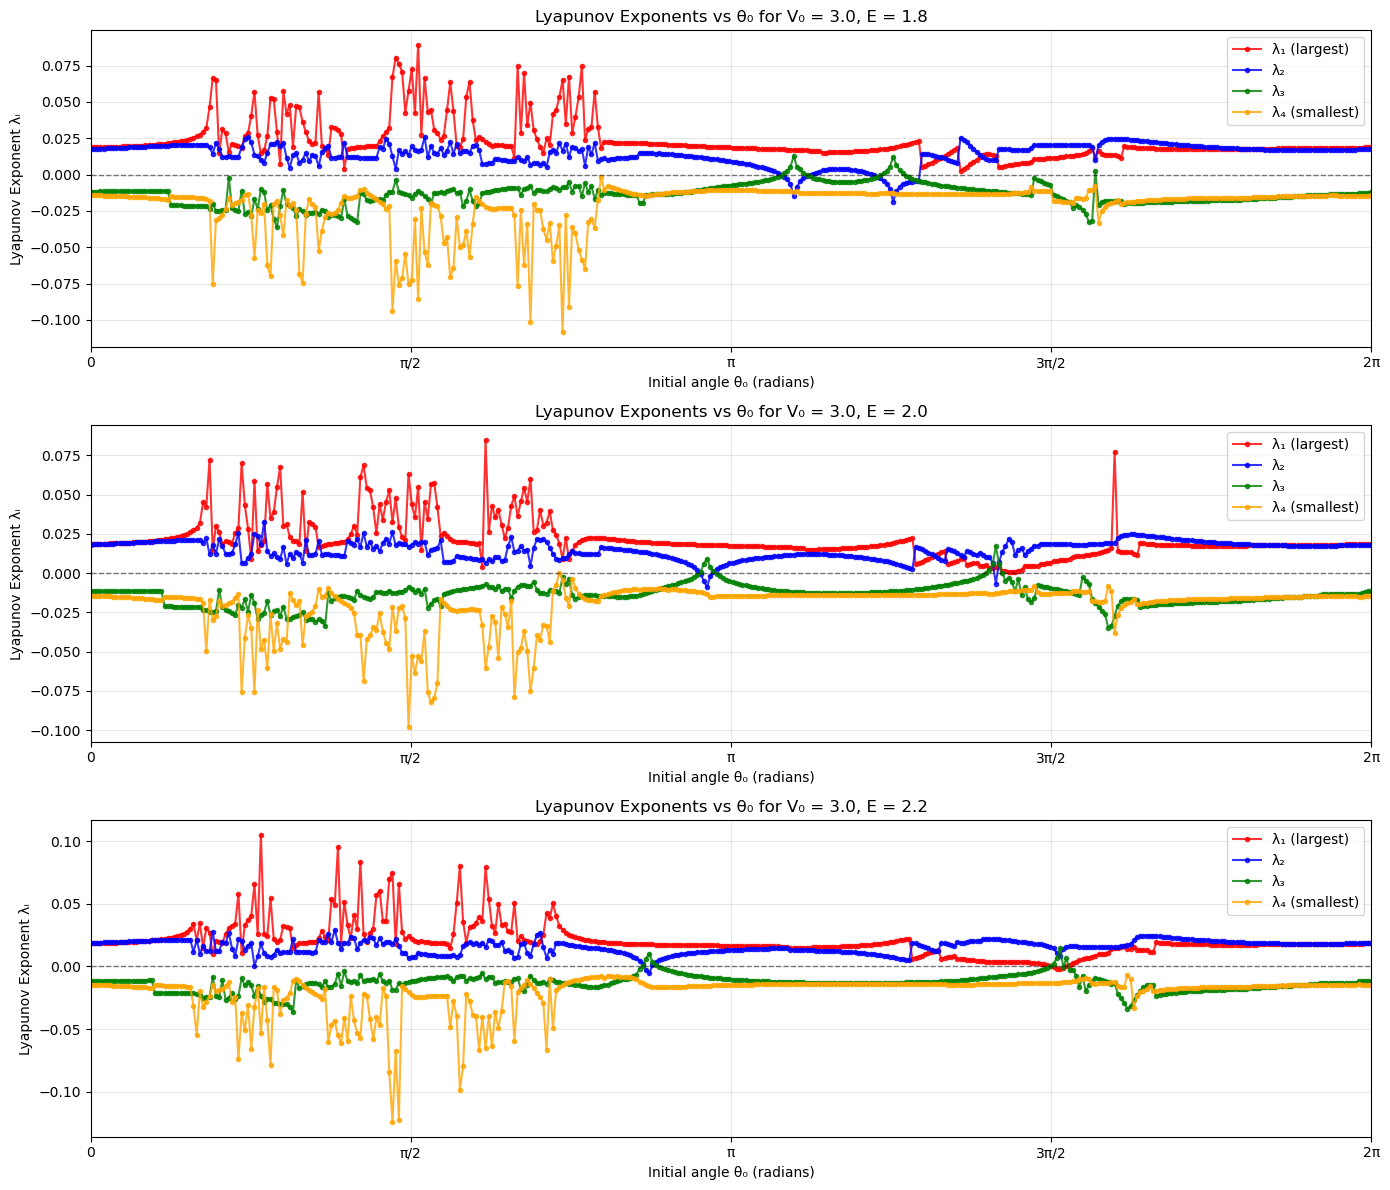


FRACTAL PATTERN ANALYSIS

Energy E = 1.8:
  Number of valid θ₀ points: 400
  λ1: 0.022589 ± 0.013491 [0.002551, 0.089413]
    → High variability detected (CV = 0.60)
  λ2: 0.013872 ± 0.007462 [-0.018705, 0.025958]
    → High variability detected (CV = 0.54)
  λ3: -0.013247 ± 0.007451 [-0.036369, 0.012976]
    → High variability detected (CV = 0.56)
  λ4: -0.020738 ± 0.015810 [-0.108583, -0.001493]
    → High variability detected (CV = 0.76)

Energy E = 2.0:
  Number of valid θ₀ points: 400
  λ1: 0.020986 ± 0.012547 [0.000515, 0.084955]
    → High variability detected (CV = 0.60)
  λ2: 0.014775 ± 0.005682 [-0.009053, 0.032805]
  λ3: -0.013454 ± 0.006766 [-0.034594, 0.017101]
    → High variability detected (CV = 0.50)
  λ4: -0.019932 ± 0.013755 [-0.098144, 0.000397]
    → High variability detected (CV = 0.69)

Energy E = 2.2:
  Number of valid θ₀ points: 400
  λ1: 0.020173 ± 0.013399 [-0.001944, 0.105063]
    → High variability detected (CV = 0.66)
  λ2: 0.015736 ± 0.005178 [-0.005575,

In [5]:
# Create comprehensive visualization
fig, axes = plt.subplots(len(energy_range), 1, figsize=(14, 4*len(energy_range)))
if len(energy_range) == 1:
    axes = [axes]

colors = ['red', 'blue', 'green', 'orange']
exponent_labels = ['λ₁ (largest)', 'λ₂', 'λ₃', 'λ₄ (smallest)']

for idx, energy in enumerate(energy_range):
    theta_vals, lyap_matrix = results[energy]
    
    ax = axes[idx]
    
    # Plot all four Lyapunov exponents
    for i in range(4):
        ax.plot(theta_vals, lyap_matrix[:, i], 
                color=colors[i], linewidth=1.5, alpha=0.8,
                label=exponent_labels[i], marker='o', markersize=3)
    
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.set_xlabel('Initial angle θ₀ (radians)')
    ax.set_ylabel('Lyapunov Exponent λᵢ')
    ax.set_title(f'Lyapunov Exponents vs θ₀ for V₀ = {V0_chaotic}, E = {energy}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 2*np.pi)
    
    # Add vertical lines at special angles
    special_angles = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    special_labels = ['0', 'π/2', 'π', '3π/2', '2π']
    ax.set_xticks(special_angles)
    ax.set_xticklabels(special_labels)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print("FRACTAL PATTERN ANALYSIS")
print(f"{'='*60}")

for energy in energy_range:
    theta_vals, lyap_matrix = results[energy]
    
    print(f"\nEnergy E = {energy}:")
    print(f"  Number of valid θ₀ points: {len(theta_vals)}")
    
    for i in range(4):
        lyap_values = lyap_matrix[:, i]
        mean_lyap = np.mean(lyap_values)
        std_lyap = np.std(lyap_values)
        min_lyap = np.min(lyap_values)
        max_lyap = np.max(lyap_values)
        
        print(f"  λ{i+1}: {mean_lyap:.6f} ± {std_lyap:.6f} "
              f"[{min_lyap:.6f}, {max_lyap:.6f}]")
        
        # Check for fractal-like behavior (high variability)
        coefficient_of_variation = abs(std_lyap / mean_lyap) if abs(mean_lyap) > 1e-10 else float('inf')
        if coefficient_of_variation > 0.5:
            print(f"    → High variability detected (CV = {coefficient_of_variation:.2f})")
